In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
marketing = pd.read_csv('Cust_Records.csv')
marketing.columns

Index(['Age', 'Education', 'Relationship_Status', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Accept_One', 'Cust_Accept (%)'],
      dtype='object')

In [3]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 20 columns):
Age                    2227 non-null int64
Education              2227 non-null object
Relationship_Status    2227 non-null object
Income                 2227 non-null float64
Children               2227 non-null int64
Wine ($)               2227 non-null int64
Fruit ($)              2227 non-null int64
Meat ($)               2227 non-null int64
Fish ($)               2227 non-null int64
Sweets ($)             2227 non-null int64
Gold_Products ($)      2227 non-null int64
Discount_Purchases     2227 non-null int64
Web_Purchases          2227 non-null int64
Catalog_Purchases      2227 non-null int64
Store_Purchases        2227 non-null int64
Days_Enrolled          2227 non-null float64
Avg_Purch_Freq         2227 non-null float64
Avg_Spend ($)          2227 non-null float64
Accept_One             2227 non-null int64
Cust_Accept (%)        2227 non-null float64
dtypes: float64(5), i

*Preprocessing for Customer Segmentation / Classification / Regression Below*

In [4]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

marketing_ml = marketing.drop(['Accept_One', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)

### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml, columns=['Education', 'Relationship_Status'], drop_first=False)

### Appending the categorical features to end on unskewed DF ###
ml = numerical.join(categorical[['Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']])

Text(0.5, 1.0, 'Elbow Plot')

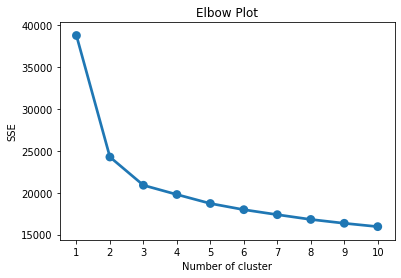

In [5]:
from sklearn.cluster import KMeans
import seaborn as sns

X = ml
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=27)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('Elbow Plot')

In [6]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml)
labels = kmeans.labels_
marketing['Cluster'] = labels
print('Cluster Counts')
print(marketing['Cluster'].value_counts())
print('\nNumerical Data - Grouped by Cluster (Means)')
marketing.groupby('Cluster').mean()

Cluster Counts
1    853
0    722
2    652
Name: Cluster, dtype: int64

Numerical Data - Grouped by Cluster (Means)


,Age,Income,Children,Wine ($),Fruit ($),Meat ($),Fish ($),Sweets ($),Gold_Products ($),Discount_Purchases,Web_Purchases,Catalog_Purchases,Store_Purchases,Days_Enrolled,Avg_Purch_Freq,Avg_Spend ($),Accept_One,Cust_Accept (%)
Cluster,,,,,,,,,,,,,,,,,,
0,45.970914,72660.262605,0.315789,588.490305,63.934903,394.867036,92.522161,65.000000,76.650970,1.447368,5.452909,5.483380,8.469529,473.970914,23.935387,63.497101,0.426593,13.850416
1,41.783118,32789.066114,1.245018,24.318875,3.720985,18.848769,5.234467,4.490035,12.906213,1.841735,1.839390,0.424385,2.909730,481.307151,77.834633,9.415135,0.132474,2.735444
2,48.415644,53925.580408,1.271472,356.641104,14.311350,107.467791,19.226994,14.943252,48.857362,3.944785,5.544479,2.489264,6.639571,473.257669,27.373839,28.665282,0.280675,6.543967


We see that one particular group had 43% of customers accept the offer at least once while also containing an average customer acceptance percentage of 14%. 

The next most promising group had 28% of customers accept the offer at least once while also containing an average customer acceptance percentage of 7%.

Least promising group had 13% of customers accept the offer at least once while also containing an average customer acceptance percentage of 3%. 

**Classification - 1)Predict Acceptance of one offer  2) Predict amount of times out of six (probability)**

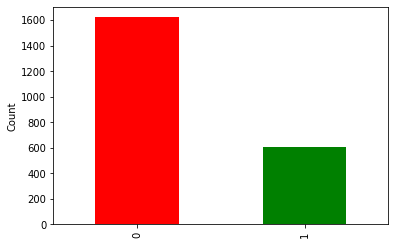

0    1623
1     604
Name: Accept_One, dtype: int64


In [7]:
### Imbalanced Classification Targets ###
my_colors = ['red', 'green']
marketing['Accept_One'].value_counts().plot(kind='bar', color=my_colors)
plt.ylabel('Count')
plt.show()
print(marketing['Accept_One'].value_counts())

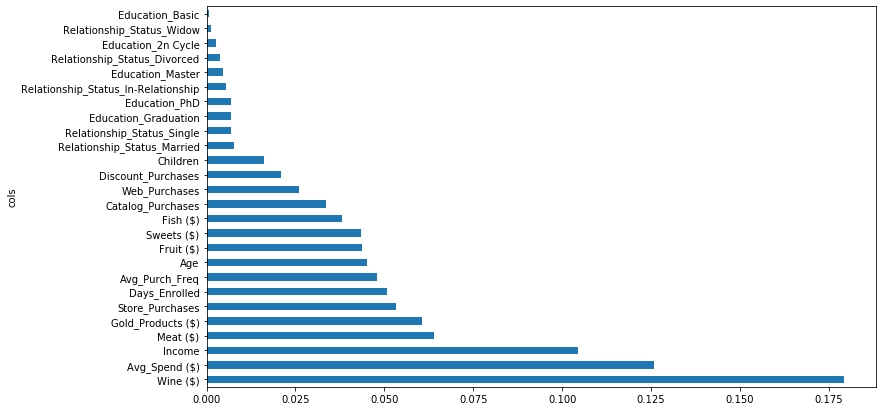


OOB Score:  0.8077844311377246

Best Params: {'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 100}

Testing Accuracy: 0.8043087971274686
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       399
           1       0.74      0.48      0.58       158

    accuracy                           0.80       557
   macro avg       0.78      0.71      0.73       557
weighted avg       0.80      0.80      0.79       557

[[372  27]
 [ 82  76]]

ROC_AUC:  0.7066717426477586


In [8]:
### RandomForest - no imbalancing techniques ###
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

X = ml.values
y = marketing['Accept_One'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=5,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
# for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
#     print('\n', '*Most Important', feature, 'Category*' )
#     new = fi.loc[fi['cols'].str.contains(feature)]
#     print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

In [ ]:
### Gradient Boosting - no imbalancing techniques ###
from xgboost import XGBClassifier
from hyperopt import hp

xgb = XGBClassifier(n_jobs=-1, random_state=27)
grid_search = GridSearchCV(xgb,
                          param_grid={ "learning_rates": [1, .5, .25, .01, .05, .01],
                                       "max_depth": list(hp.choice('max_depth', np.arange(1, 32, dtype=int))),
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "min_samples_splits": [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=5,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print(best_xgb.best_params_)
y_pred_test = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

**----Undersampling----**

In [ ]:
### Undersampling ###
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
acceptance = pd.Series(y_resampled)
acceptance.value_counts().plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())


In [ ]:
### Random Forest Classifier Using Undersampling ###
clf = RandomForestClassifier(n_jobs=-1, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=4,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_resampled, y_resampled)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
# for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
#     print('\n', '*Most Important', feature, 'Category*' )
#     new = fi.loc[fi['cols'].str.contains(feature)]
#     print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

In [ ]:
### Gradient Boost Classifier Using Undersampling ###

xgb = XGBClassifier(n_jobs=-1, random_state=27)
grid_search = GridSearchCV(xgb,
                          param_grid={ "learning_rates": [1, .5, .25, .01, .05, .01],
                                       "max_depth": list(hp.choice('max_depth', np.arange(1, 32, dtype=int))),
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "min_samples_splits": [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=4,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_resampled, y_resampled)
best_xgb = grid_search.best_estimator_
print(best_xgb.best_params_)
y_pred_test = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

**----Oversampling----**

In [ ]:
### Oversampling ###
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
acceptance = pd.Series(y_sm)
acceptance.value_counts().plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())

In [ ]:
### Random Forest Classifier Using Oversampling ###
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=6,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_sm, y_sm)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
# for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
#     print('\n', '*Most Important', feature, 'Category*' )
#     new = fi.loc[fi['cols'].str.contains(feature)]
#     print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

In [ ]:
### Gradient Boost Classifier Using Oversampling ###

xgb = XGBClassifier(n_jobs=-1, random_state=27)
grid_search = GridSearchCV(xgb,
                          param_grid={ "learning_rates": [1, .5, .25, .01, .05, .01],
                                       "max_depth": list(hp.choice('max_depth', np.arange(1, 32, dtype=int))),
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "min_samples_splits": [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=6,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_sm, y_sm)
best_xgb = grid_search.best_estimator_
print(best_xgb.best_params_)
y_pred_test = xgb.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

**After classifying a customer as Accepted (1), classify their offer acceptance rate (indicates customers that are most likely to accept the offer each time it is sent out)**

In [ ]:
### Sclicing to only included customers who accepted at least one offer ###
marketing_accept = marketing.loc[marketing['Accept_One'] == 1].reset_index(drop=True)
### Adding Accept_Rate Labels ###
marketing_accept['Accept_Rate'] = ''
for idx, row in marketing_accept.iterrows():
    if row['Cust_Accept (%)'] == ((1/6) * 100):
            marketing_accept.loc[idx, 'Accept_Rate'] = '1/6'
    elif row['Cust_Accept (%)'] == ((2/6) * 100):
            marketing_accept.loc[idx, 'Accept_Rate'] = '2/6'
    elif row['Cust_Accept (%)'] == ((3/6) * 100):
            marketing_accept.loc[idx, 'Accept_Rate'] = '3/6'
    elif row['Cust_Accept (%)'] == ((4/6) * 100):
            marketing_accept.loc[idx, 'Accept_Rate'] = '4/6'
    elif row['Cust_Accept (%)'] == ((5/6) * 100):
            marketing_accept.loc[idx, 'Accept_Rate'] = '5/6'

### Distribution of Those Who Accepted At Least One Offer ###
my_colors = ['blue', 'red', 'green', 'orange', 'purple']
marketing_accept.groupby('Accept_Rate')['Accept_Rate'].count().plot(kind='bar', color=my_colors)
plt.xlabel('Acceptance Rate')
plt.ylabel('Count')
plt.show()
print(marketing_accept.groupby('Accept_Rate')['Accept_Rate'].count())

In [ ]:
### Numerically Encode Accept_Rate ###
for idx, row in marketing_accept.iterrows():
    if row['Accept_Rate'] == '1/6':
        marketing_accept.loc[idx, 'Accept_Rate'] = 1
    elif row['Accept_Rate'] == '2/6':
        marketing_accept.loc[idx, 'Accept_Rate'] = 2
    elif row['Accept_Rate'] == '3/6':
        marketing_accept.loc[idx, 'Accept_Rate'] = 3
    elif row['Accept_Rate'] == '4/6':
        marketing_accept.loc[idx, 'Accept_Rate'] = 4
    elif row['Accept_Rate'] == '5/6':
        marketing_accept.loc[idx, 'Accept_Rate'] = 5
        
marketing_ml_accept = marketing_accept.drop(['Cluster', 'Accept_Rate', 'Accept_One', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml_accept[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)
### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml_accept, columns=['Education', 'Relationship_Status'], drop_first=False)
### Appending the categorical features to end on unskewed DF ###
ml_accept = numerical.join(categorical[['Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']], how='right')

In [ ]:
### Classifier for Accept_Rate - Gradient Boosting ###
from sklearn.metrics import roc_curve, auc

X = ml_accept.values
y = marketing_accept['Accept_Rate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
xgb = XGBClassifier()
grid_search = GridSearchCV(xgb,
                          param_grid={ "learning_rates": [1, .5, .25, .01, .05, .01],
                                       "max_depth": np.linspace(1, 32, 32, endpoint=True),
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "min_samples_splits": np.linspace(.1, 1, 10, endpoint=True),
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=3,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print(best_xgb.best_params_)
y_pred_test = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

*Regression to Predict Cust_Accept (%)*

In [89]:
### Random Forest Regressor, HyperParameter Tuning ###
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X = ml.values
y = marketing['Cust_Accept (%)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
rfr = RandomForestRegressor(n_jobs=-1, oob_score=True)
grid_search = GridSearchCV(rfr, 
                           param_grid={
                                       "n_estimators": [100, 200, 600, 1000],
                                       "min_samples_leaf": [5, 3, 2, 1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1,
                           cv=5,
                           iid=False, # just return the average score across folds
                           return_train_score=False, scoring = 'r2')
grid_search.fit(X_train, y_train)
y_pred_test = grid_search.predict(X_test)
best_rfr = grid_search.best_estimator_


 *Most Important Education Category*
                 cols       imp
 Education_Graduation  0.008699

 *Most Important Relationship_Status Category*
                        cols       imp
 Relationship_Status_Married  0.006926

 *Most Important Purchases Category*
              cols       imp
 Catalog_Purchases  0.050014

 *Most Important ($) Category*
     cols       imp
 Wine ($)  0.174912


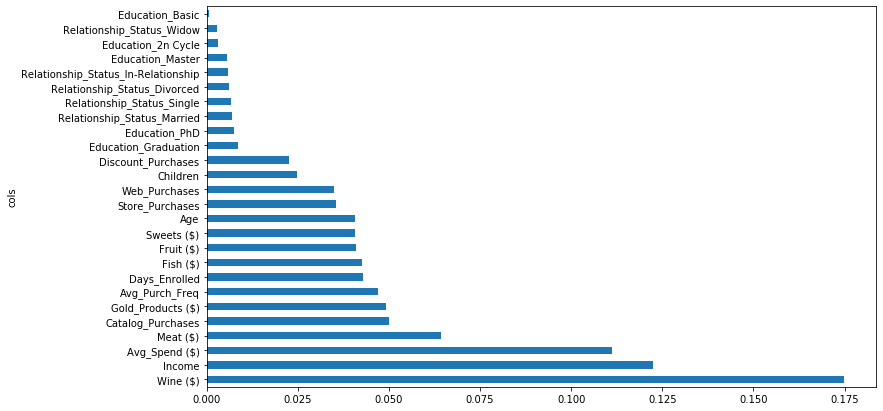


OOB Score:  0.4350199843157163

Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}

Testing RMSE: 10.366984795650158

Testing R2:  0.4331103900048644


In [90]:
### Analyzing Performance & Feature Importance Towards Cust Accept % ###

from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

fi = rf_feat_importance(best_rfr, categorical)
for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
    print('\n', '*Most Important', feature, 'Category*' )
    new = fi.loc[fi['cols'].str.contains(feature)]
    print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_rfr.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('\nTesting R2: ', grid_search.score(X_test, y_test))